In [1]:
import os
import re
import pathlib
import time
import itertools
import glob
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display
from sklearn.model_selection import KFold

from generator import *
from discriminator import *
from loss import *
from utils import *
from train import *

%load_ext autoreload
%autoreload 2

2022-05-20 21:32:35.981548: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
cities = ['la','bos', 'dc', 'nyc','chi','sp', 'bue', 'joh', 'syd', 'tok', 'par', 'mex', 'sea', 'aus']
dates = ['winter', 'spring', 'summer']
zoom = 16
shadow_path = 'data/shadows/'
height_path = 'data/heights/'
checkpoint_name = 'evaluation'
checkpoint_path = 'training_checkpoints/%s'%(checkpoint_name)

BATCH_SIZE = 2

Time taken for 1000 steps: 334.28 sec



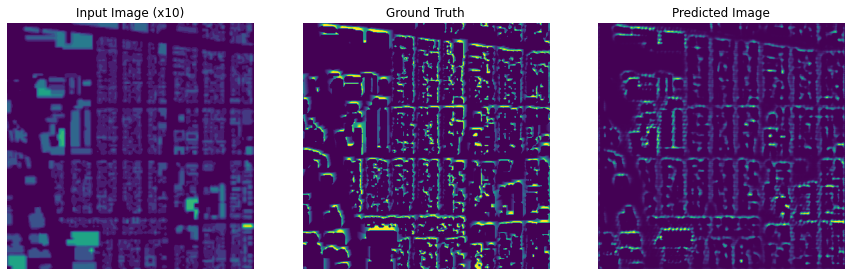

Step: 1k
..................................

In [ ]:
# Case 1: Train on K-1 Cities, Test on 1 City
for city in cities:
    
    train = cities[:]
    train.remove(city)
    test = [city]
    
    train_dataset = get_tiles(height_path, shadow_path, train, dates, zoom, 200) # 200 * 13 * 3 = 7800 tiles
    test_dataset = get_tiles(height_path, shadow_path, test, dates, zoom, 560) # 560
    
    train_dataset, test_dataset = to_tensor(train_dataset, test_dataset, BATCH_SIZE)
    
    generator = Generator(512, 512)
    discriminator = Discriminator(512, 512)
    
    fit(checkpoint_path+'/'+city, generator, discriminator, train_dataset, test_dataset, 100000)
    
    rmses, maes, r2s = get_metrics(test_dataset, generator)
        
    print('City %s rmse: %.2f mae: %.2f r2: %.2f'%(city, np.average(rmses), np.average(maes), np.average(r2s)))
    df = pd.DataFrame({'rmse': rmses, 'mae': maes, 'r2': r2s})
    
    df.to_csv('results/%s-%d/%s.csv'%(checkpoint_name, zoom, city), index=False, header=True)

In [ ]:
# Case 2: Train-Test on All Cities (5 Fold Cross Validation)
all_dataset = get_tiles(height_path, shadow_path, cities, dates, zoom, 200) 
all_dataset = np.array(all_dataset)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = 0
for train_index, test_index in kf.split(all_dataset):
    
    train_dataset = all_dataset[train_index]
    test_dataset = all_dataset[test_index]
    
    train_dataset, test_dataset = to_tensor(train_dataset, test_dataset)
    
    generator = Generator(512, 512)
    discriminator = Discriminator(512, 512)
    
    fold+=1
    fit(checkpoint_path+'/'+'fold '+str(fold), generator, discriminator, train_dataset, test_dataset, 100000)
    rmses, maes, r2s = get_metrics(test_dataset)
    
    print('Fold: %d rmse: %.2f mae: %.2f r2: %.2f'%(fold, np.average(rmses), np.average(maes), np.average(r2s)))
    df = pd.DataFrame({'rmse': rmses, 'mae': maes, 'r2': r2s})
    
    df.to_csv('results/%s-%d/fold_%d.csv'%(checkpoint_name, zoom, fold), index=False, header=True)

In [ ]:
# Case 3: Uniform Distribution of Latitudes
# Chosen Cities: Buenos Aires, Sydney, Johanesburgo, Sao Paulo, Mexico City, Los Angeles, Boston and Paris
cities = ['bue', 'joh', 'syd', 'sp', 'mex', 'la', 'bos', 'par']

train_dataset, test_dataset = get_train_test(height_path, shadow_path, train, dates, zoom, 450, BATCH_SIZE, 0.80)

generator = Generator(512, 512)
discriminator = Discriminator(512, 512)

fit(checkpoint_path+'/uniform', generator, discriminator, train_dataset, test_dataset, 100000)

rmses, maes, r2s = get_metrics(test_dataset, generator)

print('%s rmse: %.2f mae: %.2f r2: %.2f'%(city, np.average(rmses), np.average(maes), np.average(r2s)))
df = pd.DataFrame({'rmse': rmses, 'mae': maes, 'r2': r2s})

df.to_csv('results/%s-%d/uniform.csv'%(checkpoint_name, zoom, city), index=False, header=True)